<a href="https://colab.research.google.com/github/manasdhir/loan-defaulter-classification/blob/main/Decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
df1=pd.read_csv("/content/drive/MyDrive/great learning/ensemble/credit.csv")
df1.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


#EDA and data preprocessing

In [4]:
df1.shape

(1000, 17)

In [5]:
df1.describe()

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

a lot of columns are of object datatype so we need to convert them to int as decision trees do not work on object datatype

In [7]:
for i in list(df1.columns):
  if df1[i].dtype=="object":
    df1[i]==pd.Categorical(df1[i])

In [8]:
#checking value counts
for i in list(df1.columns):
  print(df1[i].value_counts())

unknown       394
< 0 DM        274
1 - 200 DM    269
> 200 DM       63
Name: checking_balance, dtype: int64
24    184
12    179
18    113
36     83
6      75
15     64
9      49
48     48
30     40
21     30
10     28
60     13
27     13
42     11
11      9
20      8
8       7
4       6
45      5
7       5
39      5
14      4
13      4
33      3
28      3
54      2
16      2
22      2
47      1
5       1
26      1
72      1
40      1
Name: months_loan_duration, dtype: int64
good         530
critical     293
poor          88
very good     49
perfect       40
Name: credit_history, dtype: int64
furniture/appliances    473
car                     337
business                 97
education                59
renovations              22
car0                     12
Name: purpose, dtype: int64
1478    3
1262    3
1258    3
1275    3
1393    3
       ..
1459    1
882     1
3758    1
1136    1
4576    1
Name: amount, Length: 921, dtype: int64
< 100 DM         603
unknown          183
100 - 500 DM

we will manually label encode these as they are ordinal data

In [9]:
replaceStruct = {
                "checking_balance":     {"< 0 DM": 1, "1 - 200 DM": 2 ,"> 200 DM": 3 ,"unknown":-1},
                "credit_history": {"critical": 1, "poor":2 , "good": 3, "very good": 4,"perfect": 5},
                 "savings_balance": {"< 100 DM": 1, "100 - 500 DM":2 , "500 - 1000 DM": 3, "> 1000 DM": 4,"unknown": -1},
                 "employment_duration":     {"unemployed": 1, "< 1 year": 2 ,"1 - 4 years": 3 ,"4 - 7 years": 4 ,"> 7 years": 5},
                "phone":     {"no": 1, "yes": 2 },
                "default":     {"no": 0, "yes": 1 }
                    }
oneHotCols=["purpose","housing","other_credit","job"]

In [10]:
df1=df1.replace(replaceStruct)
df1=pd.get_dummies(df1, columns=oneHotCols)
df1.shape

(1000, 29)

In [11]:
df1.head()

,checking_balance,months_loan_duration,credit_history,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,existing_loans_count,...,housing_other,housing_own,housing_rent,other_credit_bank,other_credit_none,other_credit_store,job_management,job_skilled,job_unemployed,job_unskilled
0,1,6,1,1169,-1,5,4,4,67,2,...,0,1,0,0,1,0,0,1,0,0
1,2,48,3,5951,1,3,2,2,22,1,...,0,1,0,0,1,0,0,1,0,0
2,-1,12,1,2096,1,4,2,3,49,1,...,0,1,0,0,1,0,0,0,0,1
3,1,42,3,7882,1,4,2,4,45,1,...,1,0,0,0,1,0,0,1,0,0
4,1,24,2,4870,1,3,3,4,53,2,...,1,0,0,0,1,0,0,1,0,0


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   checking_balance              1000 non-null   int64
 1   months_loan_duration          1000 non-null   int64
 2   credit_history                1000 non-null   int64
 3   amount                        1000 non-null   int64
 4   savings_balance               1000 non-null   int64
 5   employment_duration           1000 non-null   int64
 6   percent_of_income             1000 non-null   int64
 7   years_at_residence            1000 non-null   int64
 8   age                           1000 non-null   int64
 9   existing_loans_count          1000 non-null   int64
 10  dependents                    1000 non-null   int64
 11  phone                         1000 non-null   int64
 12  default                       1000 non-null   int64
 13  purpose_business              1000

now all columns are integers so they can be used to build a decision tree

#splitting data

In [13]:
x=df1.drop("default",axis=1)
x.shape

(1000, 28)

In [14]:
y=pd.DataFrame(df1["default"],columns=["default"])
y.shape

(1000, 1)

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=1)

#training decision tree with gini impurity without regularization

In [16]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)#same can be dont with criterion as entropy
dTree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=1)

##checking scores

In [17]:
dTree.score(x_train,y_train)

1.0

In [18]:
dTree.score(x_test,y_test)

0.6933333333333334

this is an overfit model as it has 1.0 accuracy for training data and 0.69 for testing we need to regularize it.

##visualizing the tree

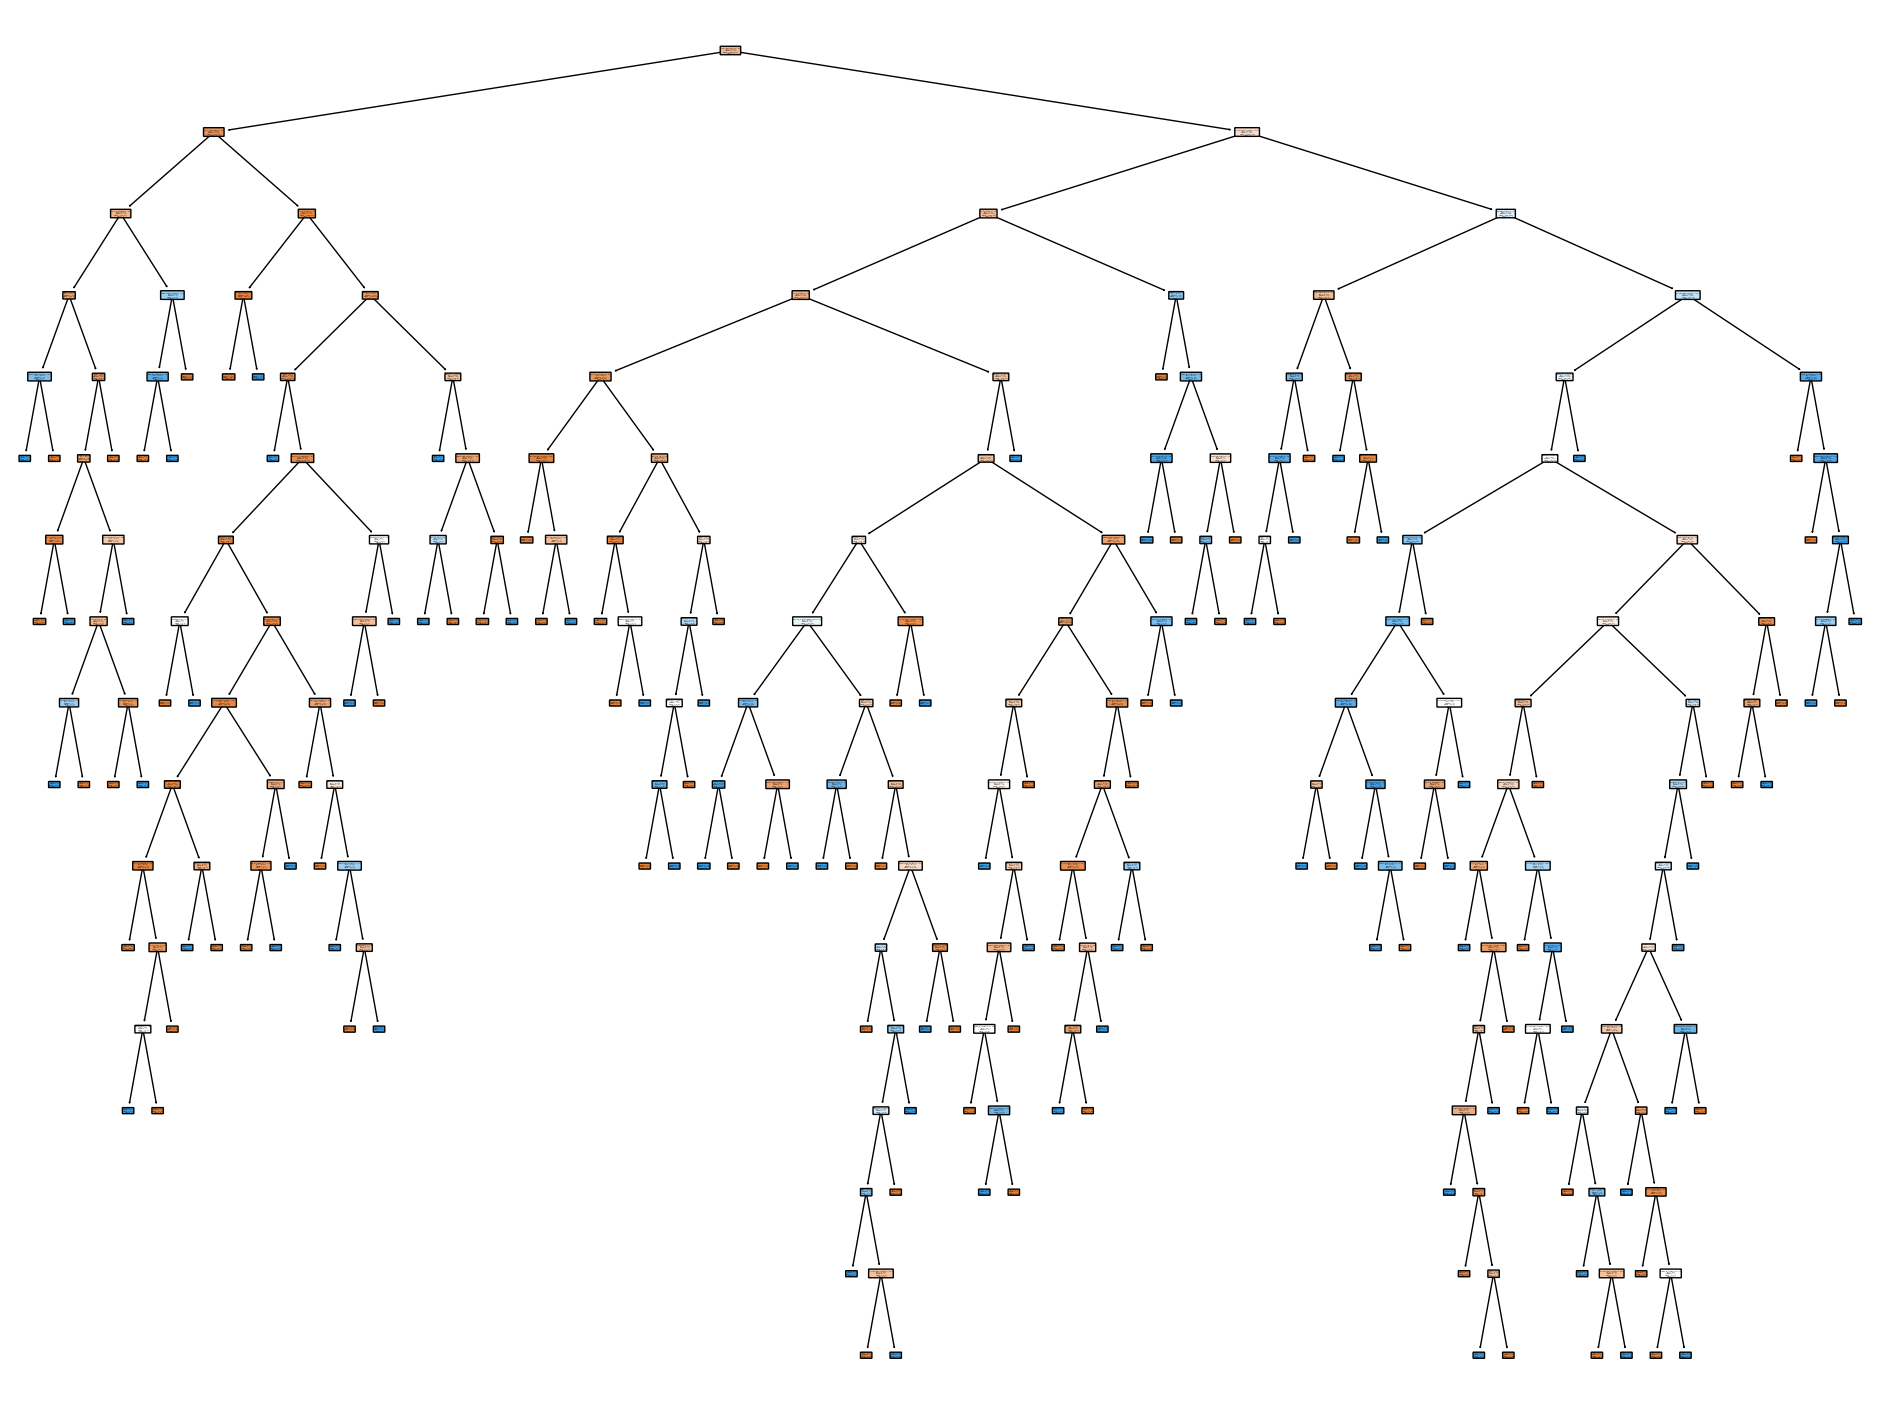

In [19]:
plt.figure(figsize=(24, 18))
plot_tree(dTree,feature_names=x.columns,class_names=["0","1"],filled=True,rounded=True)
plt.show()

#building decision tree with gini impurity with regularization

In [20]:
dTreeR = DecisionTreeClassifier(criterion = 'gini', random_state=1,max_depth=3)
dTreeR.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

##checking scores

In [21]:
dTreeR.score(x_train,y_train)

0.7528571428571429

In [22]:
dTreeR.score(x_test,y_test)

0.7433333333333333

##visualizing the tree


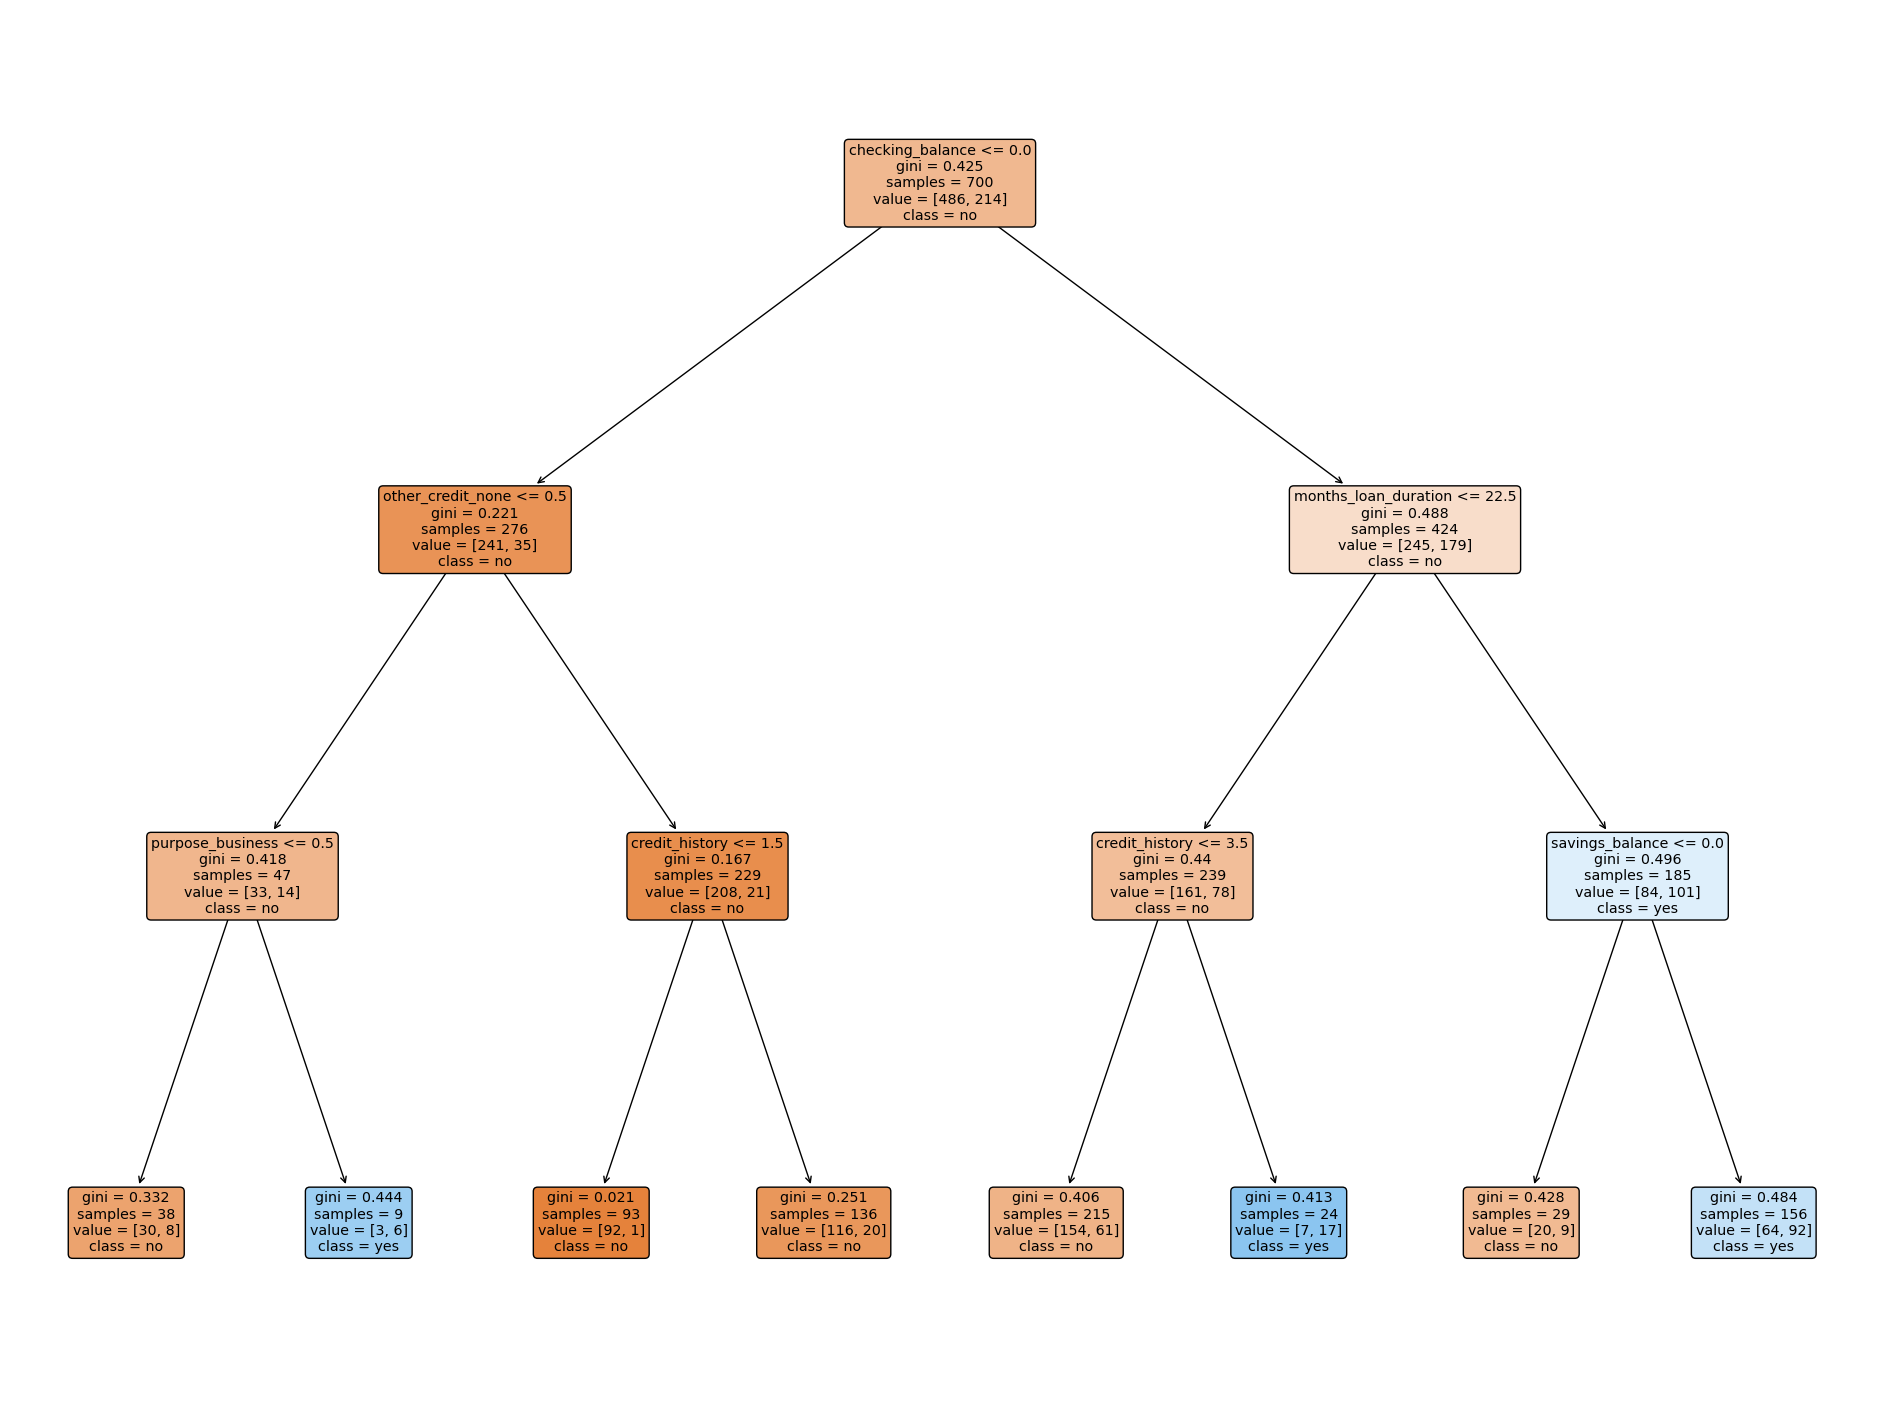

In [29]:
plt.figure(figsize=(24, 18))
plot_tree(dTreeR,feature_names=x.columns,class_names=["no","yes"],filled=True,rounded=True)
plt.show()

#checking importance of features

In [25]:
pd.DataFrame(dTreeR.feature_importances_, columns = ["Imp"], index = x_train.columns)

,Imp
checking_balance,0.492510
months_loan_duration,0.169806
credit_history,0.166109
amount,0.000000
savings_balance,0.064467
employment_duration,0.000000
percent_of_income,0.000000
years_at_residence,0.000000
age,0.000000
existing_loans_count,0.000000


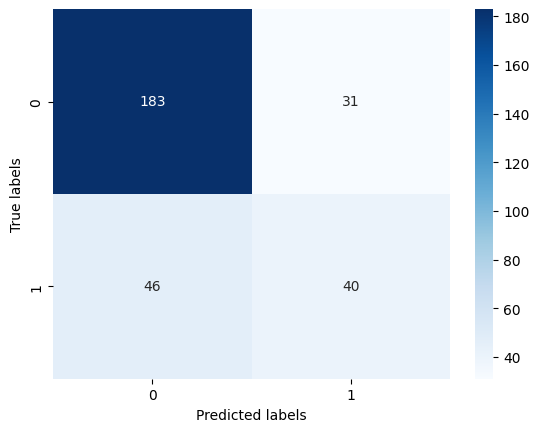

In [26]:
pred_y=dTreeR.predict(x_test)
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_y)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [39]:
pd.DataFrame(pred_y).value_counts()

0    229
1     71
dtype: int64

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred_y,target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       214
           1       0.56      0.47      0.51        86

    accuracy                           0.74       300
   macro avg       0.68      0.66      0.67       300
weighted avg       0.73      0.74      0.74       300



To calculate precision macro avg, you take the average of the precision scores for each class. Precision measures how many of the predicted positive instances were actually positive for each class.

To calculate precision weighted avg, you take a weighted average of the precision scores for each class, with the weights being the support (the number of true instances) for each class. Precision weighted avg gives more importance to classes with larger support, making it useful when you have class imbalances.

#bagging

In [40]:
from sklearn.ensemble import BaggingClassifier

In [48]:
bgcl=BaggingClassifier(base_estimator=dTree,n_estimators=50,random_state=1)#base_estimator=dTree is not needed as it will choose the most complex model by default
bgcl=bgcl.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
y_pred=bgcl.predict(x_test)
bgcl.score(x_test,y_test)

0.7733333333333333

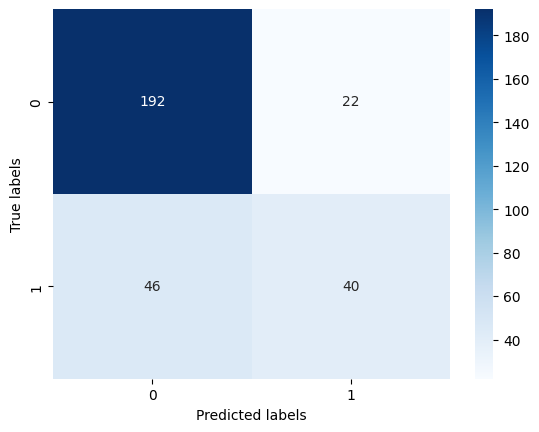

In [45]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [46]:
#using regularized decision tree
bgcl=BaggingClassifier(base_estimator=dTreeR,n_estimators=50,random_state=1)
bgcl=bgcl.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [47]:
y_pred=bgcl.predict(x_test)
bgcl.score(x_test,y_test)

0.7333333333333333

the accuracy decreases when we use the regularized model as it is less complex than the unregularized model,since a lot of trees are combined in bagging , more complex model is beneficial for it .

#boosting

#adaboosting

unlike bagging boosting requires simple models as the successive models build upon the errors of the previous model , thus if it is assigned a complex model it will perform poorly , the default setting of this model is a decision tree with max depth as 1.

In [50]:
from sklearn.ensemble import AdaBoostClassifier
clf=AdaBoostClassifier(base_estimator=dTree,n_estimators=12,random_state=1)
clf.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                   n_estimators=12, random_state=1)

In [51]:
clf.score(x_test,y_test)

0.6866666666666666

In [52]:
from sklearn.ensemble import AdaBoostClassifier
clf=AdaBoostClassifier(base_estimator=dTreeR,n_estimators=12,random_state=1)
clf.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   n_estimators=12, random_state=1)

In [54]:
clf.score(x_test,y_test)

0.6633333333333333

In [55]:
from sklearn.ensemble import AdaBoostClassifier
clf=AdaBoostClassifier(n_estimators=12,random_state=1)
clf.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(n_estimators=12, random_state=1)

In [56]:
clf.score(x_test,y_test)

0.7266666666666667

the default setting gives the best performance

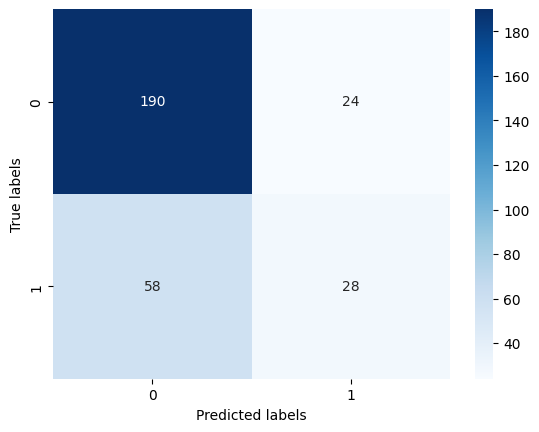

In [58]:
y_pred=clf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

##gradient descent boosting

gradient descent boosting is generally used for regression as the first models makes predictions and then the second model predicts the residuals for the first model and so on , but it can be used for classification by choosing an appropriate loss function

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50,random_state=1)
gbcl = gbcl.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [62]:
y_predict = gbcl.predict(x_test)
print(gbcl.score(x_test, y_test))

0.74


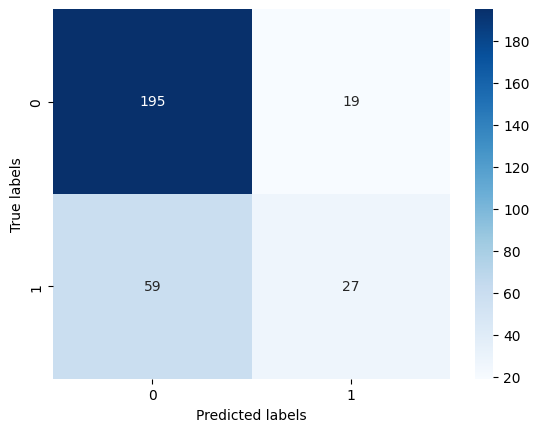

In [63]:
cm=confusion_matrix(y_test, y_predict,labels=[0, 1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

#random forest

random forest classifier is very close to bagging , in bagging we take random subsets of data and then train n models on it but in random forests we first subset the rows to build a tree and then for every branch of the tree we subset the columns again and allow each branch to pick only one of those subsetted columns.


In a Random Forest classifier, the max_features parameter is a hyperparameter that determines the maximum number of features (variables) each individual decision tree in the forest can consider when making a split or decision. It can be set to different values to control the randomness and diversity of the individual trees in the ensemble.

When max_features is set to its default value, which is typically "auto" or "sqrt," it means that each tree in the forest is allowed to consider the square root of the total number of features. This helps introduce randomness and diversity among the trees.

The choice of max_features impacts the diversity of the trees in the Random Forest. Smaller values make the trees more diverse, as they are forced to consider a subset of features, which can reduce overfitting. Larger values make the trees more similar to each other, potentially increasing predictive accuracy but risking overfitting.

In [64]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50, random_state=1,max_features=12)
rfcl = rfcl.fit(x_train, y_train)

<ipython-input-64-95e3cd43d58e>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfcl = rfcl.fit(x_train, y_train)


In [66]:
y_predict = rfcl.predict(x_test)
print(rfcl.score(x_test, y_test))
cm=confusion_matrix(y_test, y_predict,labels=[0, 1])

0.7766666666666666


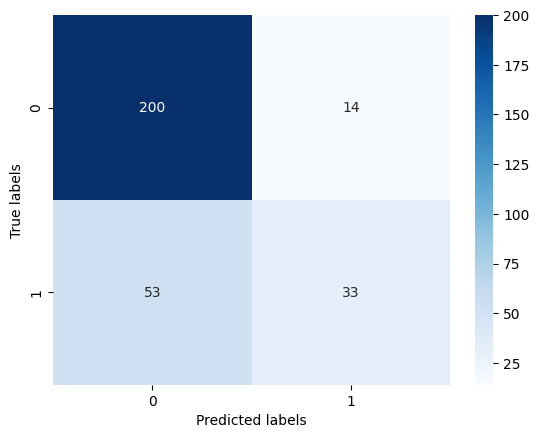

In [67]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()